#1. PERKENALAN

In [ ]:
'''
Nama  : Rugaya Muksin BSA
Batch : 006
Phase : 2
ML    : 2

'''

INTRODUCTION & PROBLEM STATEMENT

---
Penyakit kulit adalah kelainan kulit yang diakibatkan adanya jamur, kuman, parasit, virus maupun infeksi yang dapat menyerang siapa saja. Penyakit kulit dapat menyerang seluruh atau sebagian tubuh tertentu dan dapat membahayakan kondisi kesehatan penderita jika tidak ditangani dengan serius.

Penyakit kulit sering disepelekan karena dianggap tidak mempengaruhi kinerja organ dalam seperti jantung, hati, dll. Namun, penyakit kulit bisa sangat menggangu aktivitas sehari-hari dengan berbagai macam gangguan seperti gatal, perih, dll. Disamping itu jika tidak segera ditangani, area penyakit kulitnya bisa semakin melebar dan dapat mempengaruhi kenyamanan diri dan orang sekitar. Penyakit kulit juga dapat bersifat menular.

Kesadaran dini dan kecepatan penanganan penyakit kulit merupakan tindakan yang sangat diperlukan. Diperlukan sebuah telemedicine untuk membantu mengedukasi penderita penyakit kulit, untuk mengenali jenis penyakit kulit yang diderita dan tingkat keparahannya.

HOW I SOLVE THE PROBLEMS AS A DATA SCIENTIST

---

1.   Membangun model terbaik untuk klasifikasi jenis penyakit kulit dengan menggunakan salah satu algoritma deep learning yaitu CNN 
2.   Membuat deployment agar user (penderita penyakit kulit) mudah menggunakan telemedicine yang dibangun dengan model CNN

DATASET

---

Source of dataset : https://www.kaggle.com/syedaun/20-skin-disease-directories-with-face-images

Saya hanya menggunakan 8 jenis penyakit kulit dari source dataset diatas, kemudian 7 dari 8 kelas tersebut saya lakukan downsampling ke 100 data gambar. Ini source dataset yang saya gunakan setelah dilakukan dua tahapan diatas: https://drive.google.com/drive/folders/1aE1ZRr3GyzMy4ypD_ml1iV4opIzMuB2P?usp=sharing

#2. IMPORT LIBRARIES

In [1]:
#Untuk Load Data, EDA dan Preprocessing Data
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
from tqdm.notebook import tqdm as tq
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, ZeroPadding2D
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py

#Visualisasi
import matplotlib.pyplot as plt

#3. DATA LOADING

In [2]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
mypath = '/content/drive/My Drive/skin_disease'

#4. EDA & DATA PREPROCESSING

In [4]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [5]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
Acne and Rosacea Photos                                               100
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions    100
Atopic Dermatitis Photos                                              100
Light Diseases and Disorders of Pigmentation                          100
Lupus and other Connective Tissue diseases                             90
Tinea Ringworm Candidiasis and other Fungal Infections                100
Vascular Tumors                                                       100
Warts Molluscum and other Viral Infections                            100
dtype: int64

In [6]:
#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

In [7]:
# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=28)

In [8]:
# kemudian data train dibagi menjadi 2 sehingga menjadi data train dan data validation.
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=28)

In [9]:
# menyatukan kedalam masing-masing dataframe

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [10]:
print('train size', len(df_tr))
print('val size', len(df_te))
print('test size', len(df_val))

train size 568
val size 158
test size 64


In [11]:
# melihat proporsi pada masing masing set apakah sudah ok atau masih ada yang ingin diubah
df_all = df_tr.append([df_te,df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

#cek sample datanya
df_all.sample(3)


set         tag                                                               
test        Acne and Rosacea Photos                                               22
            Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions    17
            Atopic Dermatitis Photos                                              17
            Light Diseases and Disorders of Pigmentation                          24
            Lupus and other Connective Tissue diseases                            20
            Tinea Ringworm Candidiasis and other Fungal Infections                19
            Vascular Tumors                                                       22
            Warts Molluscum and other Viral Infections                            17
train       Acne and Rosacea Photos                                               73
            Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions    74
            Atopic Dermatitis Photos                                  

,path,tag,set
86,/content/drive/My Drive/skin_disease/Acne and ...,Acne and Rosacea Photos,train
503,/content/drive/My Drive/skin_disease/Lupus and...,Lupus and other Connective Tissue diseases,train
649,/content/drive/My Drive/skin_disease/Atopic De...,Atopic Dermatitis Photos,test


In [ ]:
df.head()

,path,file_name,tag
0,/content/drive/My Drive/skin_disease/Acne and ...,07rhnophymas0321051.jpg,Acne and Rosacea Photos
1,/content/drive/My Drive/skin_disease/Acne and ...,07PerioralDermEye.jpg,Acne and Rosacea Photos
2,/content/drive/My Drive/skin_disease/Acne and ...,07Rhinophyma1.jpg,Acne and Rosacea Photos
3,/content/drive/My Drive/skin_disease/Acne and ...,acne-cystic-55.jpg,Acne and Rosacea Photos
4,/content/drive/My Drive/skin_disease/Acne and ...,acne-cystic-40.jpg,Acne and Rosacea Photos


In [12]:
datasource_path = "/content/drive/My Drive/skin_disease/"
dataset_path = "dataset/"

Memindahkan data yang sudah displit ke folder google drive, dan membuat folder train, val pada google drive.

In [13]:
for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [14]:
# view image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image Shape : {img.shape}")
  return img

Image Shape : (480, 720, 3)


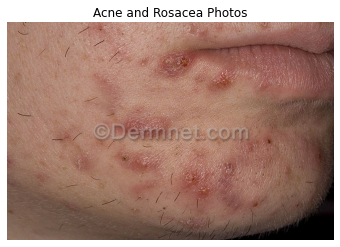

In [15]:
img = view_random_image(target_dir='dataset/train/',
                        target_class='Acne and Rosacea Photos')

Image Shape : (480, 720, 3)


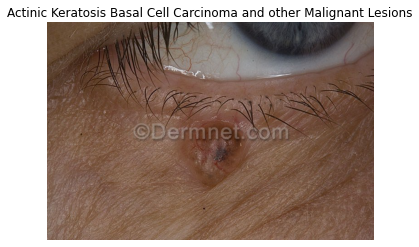

In [16]:
img = view_random_image(target_dir='dataset/train/',
                        target_class='Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions')

Image Shape : (472, 720, 3)


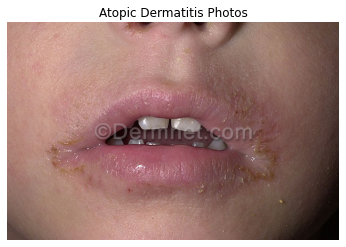

In [17]:
img = view_random_image(target_dir='dataset/train/',
                        target_class='Atopic Dermatitis Photos')

Image Shape : (474, 720, 3)


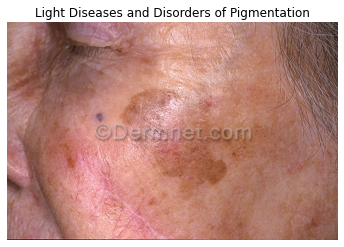

In [19]:
img = view_random_image(target_dir='dataset/train/',
                        target_class='Light Diseases and Disorders of Pigmentation')

Image Shape : (531, 720, 3)


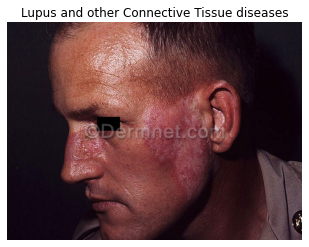

In [20]:
img = view_random_image(target_dir='dataset/train/',
                        target_class='Lupus and other Connective Tissue diseases')

Image Shape : (720, 483, 3)


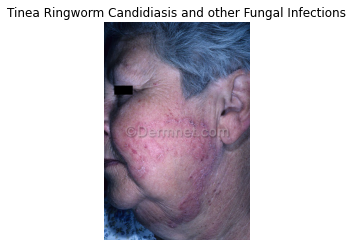

In [26]:
img = view_random_image(target_dir='dataset/train/',
                        target_class='Tinea Ringworm Candidiasis and other Fungal Infections')

Image Shape : (720, 498, 3)


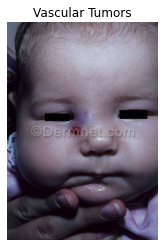

In [22]:
img = view_random_image(target_dir='dataset/train/',
                        target_class='Vascular Tumors')

Image Shape : (477, 720, 3)


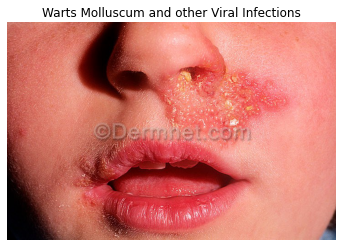

In [28]:
img = view_random_image(target_dir='dataset/train/',
                        target_class='Warts Molluscum and other Viral Infections')

###AUGMENTASI CITRA

In [14]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [15]:
train_data = train_datagen.flow_from_directory('dataset/train/',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=True)

val_data = val_datagen.flow_from_directory('dataset/validation/',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=True)

test_data = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=(224, 224),
                                                  batch_size=16,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_data.num_classes
labels = train_data.class_indices.keys()

Found 568 images belonging to 8 classes.
Found 64 images belonging to 8 classes.
Found 158 images belonging to 8 classes.


In [16]:
print(labels)

dict_keys(['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Vascular Tumors', 'Warts Molluscum and other Viral Infections'])


#5. MODELING

In [17]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

###5.1 CONVULOTION LAYER = 3

In [ ]:
model = Sequential()
model.add(Conv2D(16, 3, activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(2))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

historyc3 = model.fit(train_data,
                    epochs=15,
                    validation_data=val_data)

Epoch 1/15
36/36 [==============================] - 23s 254ms/step - loss: 2.0845 - accuracy: 0.1461 - val_loss: 2.0364 - val_accuracy: 0.1250
Epoch 2/15
36/36 [==============================] - 9s 252ms/step - loss: 2.0712 - accuracy: 0.1391 - val_loss: 2.0643 - val_accuracy: 0.1250
Epoch 3/15
36/36 [==============================] - 9s 252ms/step - loss: 2.0627 - accuracy: 0.1567 - val_loss: 2.0074 - val_accuracy: 0.1875
Epoch 4/15
36/36 [==============================] - 9s 247ms/step - loss: 2.0606 - accuracy: 0.1567 - val_loss: 2.0041 - val_accuracy: 0.2500
Epoch 5/15
36/36 [==============================] - 9s 247ms/step - loss: 2.0377 - accuracy: 0.1884 - val_loss: 1.9808 - val_accuracy: 0.1562
Epoch 6/15
36/36 [==============================] - 9s 251ms/step - loss: 2.0408 - accuracy: 0.2077 - val_loss: 1.9817 - val_accuracy: 0.0938
Epoch 7/15
36/36 [==============================] - 9s 248ms/step - loss: 2.0064 - accuracy: 0.2113 - val_loss: 1.9329 - val_accuracy: 0.1719
Epoch

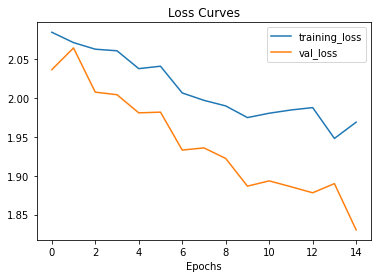

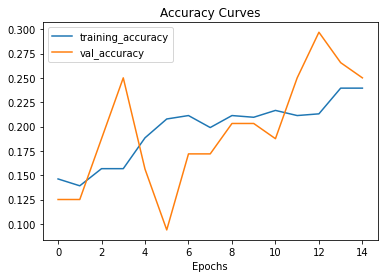

In [ ]:
plot_loss_curves(historyc3)

###5.2 CONVULOTION LAYER = 4

In [ ]:
model = Sequential()
model.add(Conv2D(16, 3, activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(2))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

historyc4 = model.fit(train_data,
                    epochs=15,
                    validation_data=val_data)

Epoch 1/15
36/36 [==============================] - 16s 410ms/step - loss: 2.0828 - accuracy: 0.1092 - val_loss: 2.0793 - val_accuracy: 0.1406
Epoch 2/15
36/36 [==============================] - 11s 294ms/step - loss: 2.0790 - accuracy: 0.1268 - val_loss: 2.1015 - val_accuracy: 0.1094
Epoch 3/15
36/36 [==============================] - 9s 249ms/step - loss: 2.0820 - accuracy: 0.1144 - val_loss: 2.0792 - val_accuracy: 0.1250
Epoch 4/15
36/36 [==============================] - 11s 318ms/step - loss: 2.0793 - accuracy: 0.1320 - val_loss: 2.0793 - val_accuracy: 0.1250
Epoch 5/15
36/36 [==============================] - 9s 250ms/step - loss: 2.0790 - accuracy: 0.1320 - val_loss: 2.0792 - val_accuracy: 0.1250
Epoch 6/15
36/36 [==============================] - 11s 298ms/step - loss: 2.0789 - accuracy: 0.1320 - val_loss: 2.0789 - val_accuracy: 0.1250
Epoch 7/15
36/36 [==============================] - 11s 293ms/step - loss: 2.0789 - accuracy: 0.1320 - val_loss: 2.0790 - val_accuracy: 0.1250
E

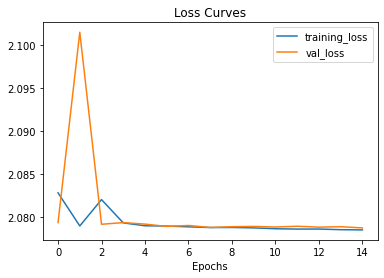

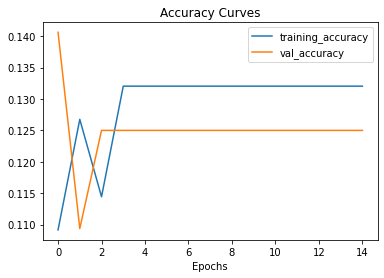

In [ ]:
plot_loss_curves(historyc4)

###5.3 CONVULOTION LAYER = 5

Terlihat modelnya yang dihasilkan cukup bagus, dari hasil visualisasi ini juga dapat dilihat bahwa semakin banyak perulangan (jumlah epoch) model semakin mendekati konvergen karena nilai akurasi meningkat dan loss menurun

In [ ]:
model = Sequential()
model.add(Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(2))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

historyc5 = model.fit(train_data,
                    epochs=15,
                    validation_data=val_data)

Epoch 1/15
36/36 [==============================] - 10s 258ms/step - loss: 2.0817 - accuracy: 0.1180 - val_loss: 2.0792 - val_accuracy: 0.1406
Epoch 2/15
36/36 [==============================] - 9s 254ms/step - loss: 2.0797 - accuracy: 0.1285 - val_loss: 2.0805 - val_accuracy: 0.0781
Epoch 3/15
36/36 [==============================] - 9s 251ms/step - loss: 2.0794 - accuracy: 0.1268 - val_loss: 2.0800 - val_accuracy: 0.0781
Epoch 4/15
36/36 [==============================] - 9s 250ms/step - loss: 2.0789 - accuracy: 0.1356 - val_loss: 2.0766 - val_accuracy: 0.1250
Epoch 5/15
36/36 [==============================] - 9s 248ms/step - loss: 2.0840 - accuracy: 0.1496 - val_loss: 2.0764 - val_accuracy: 0.1562
Epoch 6/15
36/36 [==============================] - 9s 252ms/step - loss: 2.0751 - accuracy: 0.1673 - val_loss: 2.0804 - val_accuracy: 0.1406
Epoch 7/15
36/36 [==============================] - 9s 250ms/step - loss: 2.0767 - accuracy: 0.1197 - val_loss: 2.0769 - val_accuracy: 0.1250
Epoch

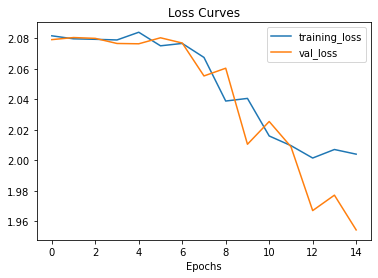

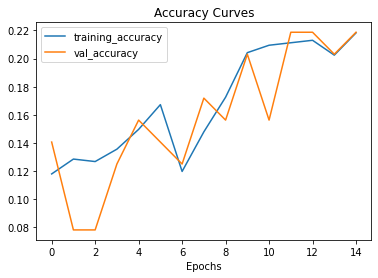

In [ ]:
plot_loss_curves(historyc5)

###5.4 BEST PROPORTION OF CONVOLUTIONAL LAYER

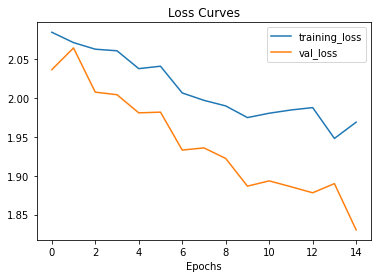

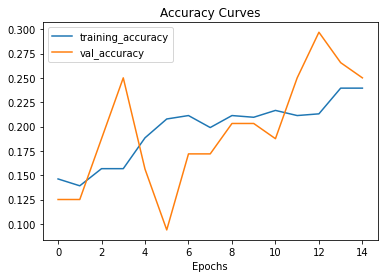

In [ ]:
plot_loss_curves(historyc3)

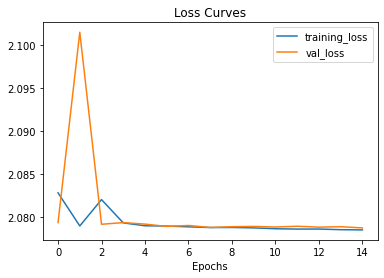

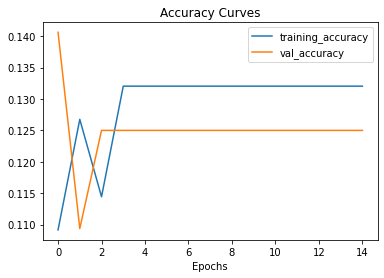

In [ ]:
plot_loss_curves(historyc4)

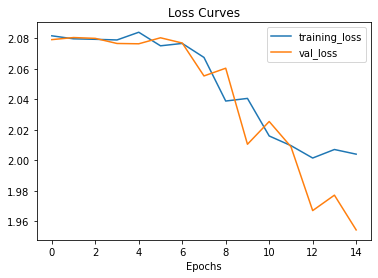

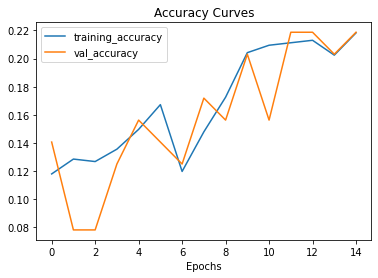

In [ ]:
plot_loss_curves(historyc5)

Dari hasil visualisasi ketiga jumlah konvolusi layer, jumlah konvolusi dengan model yang menghasilkan akurasi yang stabil dan mendekati konvergen adalah sebesar 5.

#6. MODEL IMPROVEMENT

Pada model improvement ini saya menambahkan padding dan stride pada lapisan konvolusi. Stride sejumlah 1, pergeseran perkalian matriks pada lapisan konvolusi sebanyak 1 matriks. 

Penambahan padding ini digunakan dengan tujuan untuk memanipulasi dimensi output dari konvolusi layer (Feature Map). Karena dimensi output konvolusi selalu lebih kecil dari inputnya. Penggunaan padding dapat meningkatkan performa dari model karena conv. filter akan fokus pada informasi yang sebenarnya yaitu yang berada diantara zero padding tersebut.

Padding bernilai same (sama) untuk memastikan bahwa filter diterapkan ke semua elemen input.

Akan ada beberapa experiment untuk mendapatkan model terbaik, yaitu:

1. Fungsi aktivasi
2. Optimizers
3. Learning rate

###6.1 FUNGSI AKTIVASI

Pada tahapan ini akan dilakukan percobaan beberapa jenis fungsi aktivasi (ReLU, elu dan LeakyReLU) dengan optimizer adam untuk mencari model terbaik.

#####RELU

Epoch 1/10
36/36 [==============================] - 19s 427ms/step - loss: 2.0818 - accuracy: 0.1232 - val_loss: 2.0793 - val_accuracy: 0.0781
Epoch 2/10
36/36 [==============================] - 13s 357ms/step - loss: 2.0796 - accuracy: 0.1250 - val_loss: 2.0792 - val_accuracy: 0.1406
Epoch 3/10
36/36 [==============================] - 14s 382ms/step - loss: 2.0790 - accuracy: 0.1250 - val_loss: 2.0797 - val_accuracy: 0.1250
Epoch 4/10
36/36 [==============================] - 9s 262ms/step - loss: 2.0791 - accuracy: 0.1320 - val_loss: 2.0798 - val_accuracy: 0.1250
Epoch 5/10
36/36 [==============================] - 10s 263ms/step - loss: 2.0788 - accuracy: 0.1320 - val_loss: 2.0791 - val_accuracy: 0.1250
Epoch 6/10
36/36 [==============================] - 10s 264ms/step - loss: 2.0786 - accuracy: 0.1320 - val_loss: 2.0790 - val_accuracy: 0.1250
Epoch 7/10
36/36 [==============================] - 9s 261ms/step - loss: 2.0787 - accuracy: 0.1320 - val_loss: 2.0790 - val_accuracy: 0.1250
E

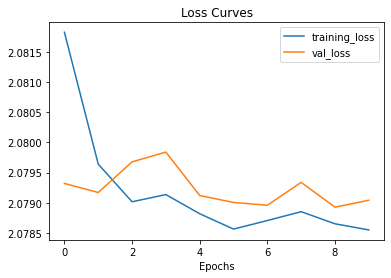

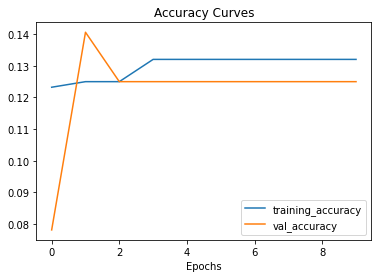

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_relu = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history_relu)

##### ELU

Epoch 1/10
36/36 [==============================] - 13s 325ms/step - loss: 2.2069 - accuracy: 0.1074 - val_loss: 2.0799 - val_accuracy: 0.1250
Epoch 2/10
36/36 [==============================] - 10s 266ms/step - loss: 2.0853 - accuracy: 0.1285 - val_loss: 2.0749 - val_accuracy: 0.1406
Epoch 3/10
36/36 [==============================] - 10s 267ms/step - loss: 2.0837 - accuracy: 0.1197 - val_loss: 2.0774 - val_accuracy: 0.1250
Epoch 4/10
36/36 [==============================] - 10s 267ms/step - loss: 2.0808 - accuracy: 0.1162 - val_loss: 2.0779 - val_accuracy: 0.1250
Epoch 5/10
36/36 [==============================] - 10s 266ms/step - loss: 2.0799 - accuracy: 0.1144 - val_loss: 2.0796 - val_accuracy: 0.1406
Epoch 6/10
36/36 [==============================] - 10s 268ms/step - loss: 2.0813 - accuracy: 0.0968 - val_loss: 2.0798 - val_accuracy: 0.1406
Epoch 7/10
36/36 [==============================] - 10s 266ms/step - loss: 2.0795 - accuracy: 0.1232 - val_loss: 2.0769 - val_accuracy: 0.1250

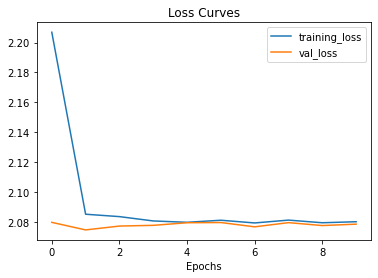

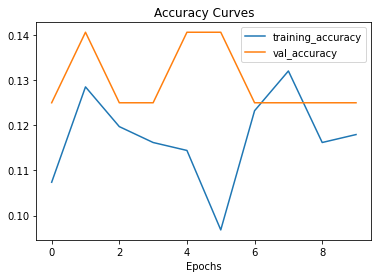

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='elu', input_shape=(224,224,3)))
model.add(Conv2D(16, (3, 3), activation='elu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='elu'))
model.add(Conv2D(32, (3, 3), activation='elu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='elu'))
model.add(Conv2D(128, (3, 3), activation='elu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_elu = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history_elu)

#####LEAKY RELU

Epoch 1/10
36/36 [==============================] - 12s 302ms/step - loss: 2.0835 - accuracy: 0.0986 - val_loss: 2.0794 - val_accuracy: 0.1406
Epoch 2/10
36/36 [==============================] - 10s 269ms/step - loss: 2.0797 - accuracy: 0.1285 - val_loss: 2.0790 - val_accuracy: 0.1250
Epoch 3/10
36/36 [==============================] - 10s 267ms/step - loss: 2.0795 - accuracy: 0.1250 - val_loss: 2.0790 - val_accuracy: 0.1250
Epoch 4/10
36/36 [==============================] - 10s 268ms/step - loss: 2.0795 - accuracy: 0.1320 - val_loss: 2.0785 - val_accuracy: 0.1250
Epoch 5/10
36/36 [==============================] - 10s 267ms/step - loss: 2.0788 - accuracy: 0.1320 - val_loss: 2.0784 - val_accuracy: 0.1250
Epoch 6/10
36/36 [==============================] - 10s 268ms/step - loss: 2.0794 - accuracy: 0.1127 - val_loss: 2.0787 - val_accuracy: 0.1250
Epoch 7/10
36/36 [==============================] - 10s 268ms/step - loss: 2.0788 - accuracy: 0.1320 - val_loss: 2.0787 - val_accuracy: 0.1250

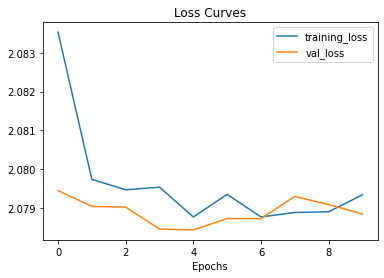

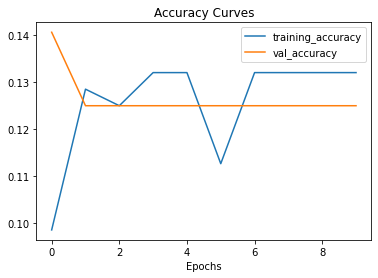

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='LeakyReLU', input_shape=(224,224,3)))
model.add(Conv2D(16, (3, 3), activation='LeakyReLU'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='LeakyReLU'))
model.add(Conv2D(32, (3, 3), activation='LeakyReLU'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='LeakyReLU'))
model.add(Conv2D(64, (3, 3), activation='LeakyReLU'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='LeakyReLU'))
model.add(Conv2D(128, (3, 3), activation='LeakyReLU'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='LeakyReLU'))
model.add(Dense(64, activation='LeakyReLU'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_leakyrelu = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history_leakyrelu)

#####BEST ACTIVATION FUNCTION FOR THIS CASE

Dari hasil experiment ketiga fungsi aktivasi, based on visualization fungsi aktivasi yang menghasilkan model yang lebih stabil dan mendekati konvergen adalah fungsi aktivasi ReLU.

###6.2 OPTIMIZERS WITH DEFAULT LEARNING RATE (0.001)

Pada tahapan ini akan dilakukan percobaan beberapa jenis optimizers (Nadam, Adamax dan RMSprop) dengan default learning rate (0.001) untuk mencari model terbaik

#####NADAM

Epoch 1/10
36/36 [==============================] - 14s 297ms/step - loss: 2.0978 - accuracy: 0.0845 - val_loss: 2.0777 - val_accuracy: 0.2031
Epoch 2/10
36/36 [==============================] - 9s 257ms/step - loss: 2.2209 - accuracy: 0.1215 - val_loss: 2.0774 - val_accuracy: 0.1562
Epoch 3/10
36/36 [==============================] - 9s 253ms/step - loss: 2.0781 - accuracy: 0.1303 - val_loss: 2.0414 - val_accuracy: 0.2344
Epoch 4/10
36/36 [==============================] - 9s 252ms/step - loss: 2.0574 - accuracy: 0.1725 - val_loss: 1.9801 - val_accuracy: 0.1719
Epoch 5/10
36/36 [==============================] - 10s 284ms/step - loss: 2.0163 - accuracy: 0.2060 - val_loss: 1.9972 - val_accuracy: 0.1406
Epoch 6/10
36/36 [==============================] - 15s 422ms/step - loss: 2.0034 - accuracy: 0.2236 - val_loss: 1.9169 - val_accuracy: 0.2031
Epoch 7/10
36/36 [==============================] - 13s 376ms/step - loss: 1.9816 - accuracy: 0.2359 - val_loss: 1.9291 - val_accuracy: 0.2031
Ep

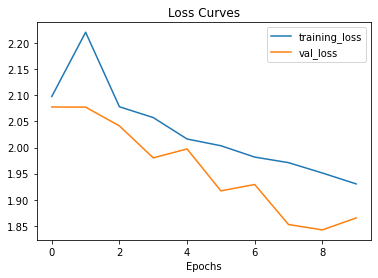

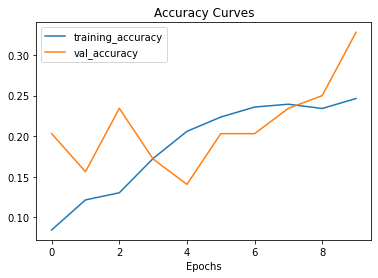

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

history_leakyrelu = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history_leakyrelu)

#####ADAMAX

Epoch 1/10
36/36 [==============================] - 10s 263ms/step - loss: 2.0843 - accuracy: 0.1039 - val_loss: 2.0727 - val_accuracy: 0.1406
Epoch 2/10
36/36 [==============================] - 9s 253ms/step - loss: 2.0770 - accuracy: 0.1426 - val_loss: 2.0771 - val_accuracy: 0.1406
Epoch 3/10
36/36 [==============================] - 9s 254ms/step - loss: 2.0700 - accuracy: 0.1549 - val_loss: 2.0516 - val_accuracy: 0.1719
Epoch 4/10
36/36 [==============================] - 9s 254ms/step - loss: 2.0366 - accuracy: 0.1778 - val_loss: 2.0504 - val_accuracy: 0.1719
Epoch 5/10
36/36 [==============================] - 9s 254ms/step - loss: 2.0130 - accuracy: 0.2218 - val_loss: 1.9725 - val_accuracy: 0.1875
Epoch 6/10
36/36 [==============================] - 10s 282ms/step - loss: 2.0055 - accuracy: 0.2165 - val_loss: 1.9592 - val_accuracy: 0.2656
Epoch 7/10
36/36 [==============================] - 9s 253ms/step - loss: 1.9687 - accuracy: 0.2359 - val_loss: 1.9664 - val_accuracy: 0.2656
Epoc

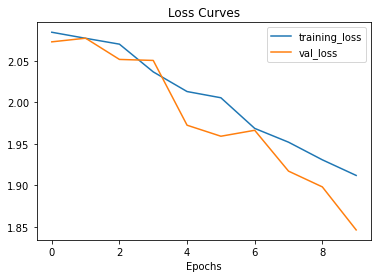

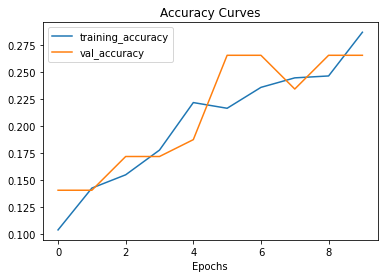

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

history_leakyrelu = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history_leakyrelu)

#####RMSPROP

Epoch 1/10
36/36 [==============================] - 10s 258ms/step - loss: 2.1015 - accuracy: 0.1092 - val_loss: 2.0797 - val_accuracy: 0.0781
Epoch 2/10
36/36 [==============================] - 9s 255ms/step - loss: 2.0825 - accuracy: 0.1285 - val_loss: 2.0815 - val_accuracy: 0.1719
Epoch 3/10
36/36 [==============================] - 9s 253ms/step - loss: 2.0852 - accuracy: 0.1620 - val_loss: 1.9961 - val_accuracy: 0.2656
Epoch 4/10
36/36 [==============================] - 11s 320ms/step - loss: 2.0501 - accuracy: 0.2060 - val_loss: 1.9147 - val_accuracy: 0.2500
Epoch 5/10
36/36 [==============================] - 9s 255ms/step - loss: 2.0054 - accuracy: 0.1831 - val_loss: 1.8733 - val_accuracy: 0.2344
Epoch 6/10
36/36 [==============================] - 9s 254ms/step - loss: 1.9819 - accuracy: 0.2201 - val_loss: 1.8152 - val_accuracy: 0.3125
Epoch 7/10
36/36 [==============================] - 10s 280ms/step - loss: 1.9721 - accuracy: 0.2500 - val_loss: 1.8347 - val_accuracy: 0.3594
Epo

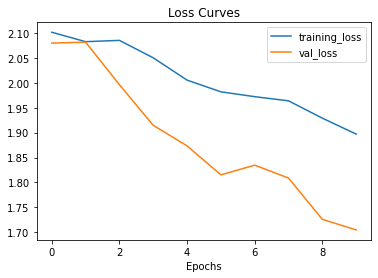

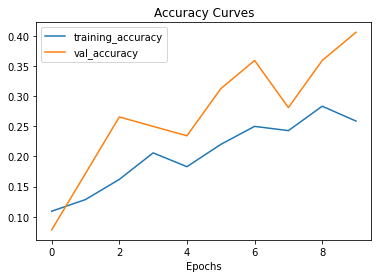

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

history_leakyrelu = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history_leakyrelu)

#####BEST OPTIMIZERS FOR THIS CASE

Dari hasil experiment ketiga optimizers, based on visualization optimizer yang menghasilkan model yang lebih stabil dan mendekati konvergen adalah Adamax dengan default learning rate (0.001)

###6.3 LEARNING RATE

Pada tahapan ini akan dilakukan percobaan beberapa nilai learning rate (0.1, 0.01, 0.0001) untuk mencari model terbaik.

#####LEARNING RATE 0.1

Epoch 1/10
36/36 [==============================] - 15s 392ms/step - loss: 266394.7812 - accuracy: 0.1479 - val_loss: 9.2342 - val_accuracy: 0.1250
Epoch 2/10
36/36 [==============================] - 13s 373ms/step - loss: 2.2496 - accuracy: 0.1250 - val_loss: 2.0743 - val_accuracy: 0.1406
Epoch 3/10
36/36 [==============================] - 9s 251ms/step - loss: 2.0818 - accuracy: 0.1303 - val_loss: 2.0744 - val_accuracy: 0.1562
Epoch 4/10
36/36 [==============================] - 9s 253ms/step - loss: 2.0840 - accuracy: 0.1021 - val_loss: 2.0774 - val_accuracy: 0.1406
Epoch 5/10
36/36 [==============================] - 10s 282ms/step - loss: 2.0818 - accuracy: 0.1162 - val_loss: 2.0781 - val_accuracy: 0.1250
Epoch 6/10
36/36 [==============================] - 9s 252ms/step - loss: 2.0806 - accuracy: 0.1162 - val_loss: 2.0775 - val_accuracy: 0.1250
Epoch 7/10
36/36 [==============================] - 9s 251ms/step - loss: 2.0807 - accuracy: 0.1320 - val_loss: 2.0801 - val_accuracy: 0.125

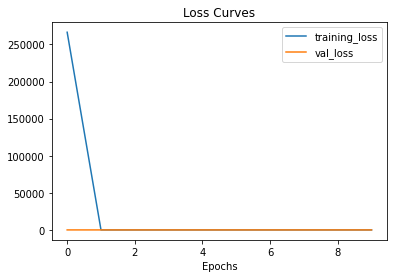

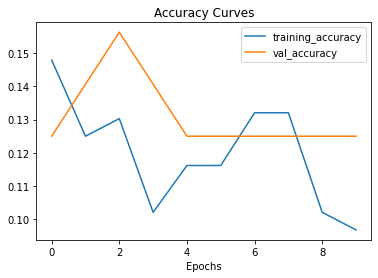

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

history_leakyrelu = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history_leakyrelu)

#####LEARNING RATE 0.01

Epoch 1/10
36/36 [==============================] - 10s 260ms/step - loss: 5.9789 - accuracy: 0.1144 - val_loss: 2.0836 - val_accuracy: 0.0781
Epoch 2/10
36/36 [==============================] - 9s 256ms/step - loss: 2.1078 - accuracy: 0.1285 - val_loss: 2.0799 - val_accuracy: 0.0938
Epoch 3/10
36/36 [==============================] - 9s 252ms/step - loss: 2.0773 - accuracy: 0.1373 - val_loss: 2.0641 - val_accuracy: 0.1094
Epoch 4/10
36/36 [==============================] - 9s 253ms/step - loss: 2.0626 - accuracy: 0.1567 - val_loss: 2.0557 - val_accuracy: 0.1875
Epoch 5/10
36/36 [==============================] - 9s 251ms/step - loss: 2.0519 - accuracy: 0.1813 - val_loss: 2.0583 - val_accuracy: 0.1719
Epoch 6/10
36/36 [==============================] - 9s 259ms/step - loss: 2.0407 - accuracy: 0.1937 - val_loss: 2.0360 - val_accuracy: 0.1562
Epoch 7/10
36/36 [==============================] - 9s 255ms/step - loss: 2.0132 - accuracy: 0.2165 - val_loss: 2.0278 - val_accuracy: 0.1719
Epoch

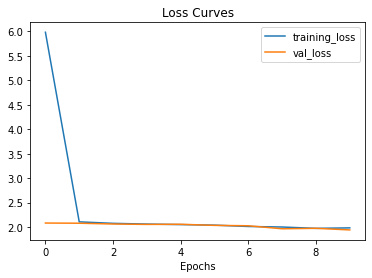

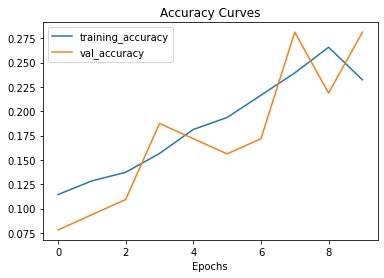

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

history_leakyrelu = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history_leakyrelu)

#####LEARNING RATE 0.0001

Epoch 1/10
36/36 [==============================] - 10s 261ms/step - loss: 2.0814 - accuracy: 0.1250 - val_loss: 2.0715 - val_accuracy: 0.1719
Epoch 2/10
36/36 [==============================] - 9s 253ms/step - loss: 2.0730 - accuracy: 0.1602 - val_loss: 2.0654 - val_accuracy: 0.1406
Epoch 3/10
36/36 [==============================] - 9s 257ms/step - loss: 2.0672 - accuracy: 0.1585 - val_loss: 2.0557 - val_accuracy: 0.1719
Epoch 4/10
36/36 [==============================] - 9s 254ms/step - loss: 2.0613 - accuracy: 0.1708 - val_loss: 2.0481 - val_accuracy: 0.2031
Epoch 5/10
36/36 [==============================] - 9s 252ms/step - loss: 2.0508 - accuracy: 0.1919 - val_loss: 2.0345 - val_accuracy: 0.1719
Epoch 6/10
36/36 [==============================] - 9s 256ms/step - loss: 2.0317 - accuracy: 0.2183 - val_loss: 2.0278 - val_accuracy: 0.1250
Epoch 7/10
36/36 [==============================] - 9s 255ms/step - loss: 2.0168 - accuracy: 0.2201 - val_loss: 1.9957 - val_accuracy: 0.1719
Epoch

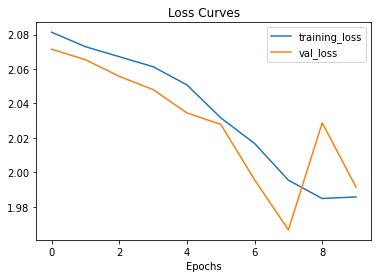

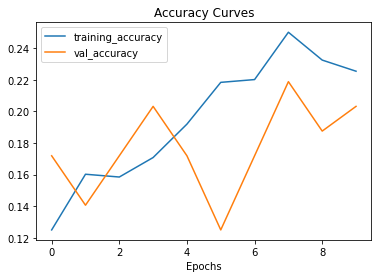

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_leakyrelu = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history_leakyrelu)

#####BEST VALUE OF LEARNING RATE FOR THIS CASE

Learning rate terbaik adalah learning rate default yaitu sebesar 0.001

###BEST MODEL ARCHITECTURE

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data)

plot_loss_curves(history)

#7. TRAINING DAN EVALUASI BEST MODEL WITH 100 EPOCHS & DROPOUT (0.2)

Epoch 1/100
36/36 - 46s - loss: 2.1009 - accuracy: 0.1303 - val_loss: 2.0793 - val_accuracy: 0.1406 - lr: 0.0010 - 46s/epoch - 1s/step
Epoch 2/100
36/36 - 44s - loss: 2.0788 - accuracy: 0.1303 - val_loss: 2.0788 - val_accuracy: 0.2031 - lr: 0.0010 - 44s/epoch - 1s/step
Epoch 3/100
36/36 - 44s - loss: 2.0784 - accuracy: 0.1373 - val_loss: 2.0785 - val_accuracy: 0.1875 - lr: 0.0010 - 44s/epoch - 1s/step
Epoch 4/100
36/36 - 44s - loss: 2.0747 - accuracy: 0.1408 - val_loss: 2.0774 - val_accuracy: 0.1875 - lr: 0.0010 - 44s/epoch - 1s/step
Epoch 5/100
36/36 - 44s - loss: 2.0719 - accuracy: 0.1461 - val_loss: 2.0740 - val_accuracy: 0.1719 - lr: 0.0010 - 44s/epoch - 1s/step
Epoch 6/100
36/36 - 44s - loss: 2.0665 - accuracy: 0.1637 - val_loss: 2.0776 - val_accuracy: 0.1406 - lr: 0.0010 - 44s/epoch - 1s/step
Epoch 7/100
36/36 - 44s - loss: 2.0572 - accuracy: 0.1708 - val_loss: 2.0720 - val_accuracy: 0.2031 - lr: 0.0010 - 44s/epoch - 1s/step
Epoch 8/100
36/36 - 44s - loss: 2.0752 - accuracy: 0.15

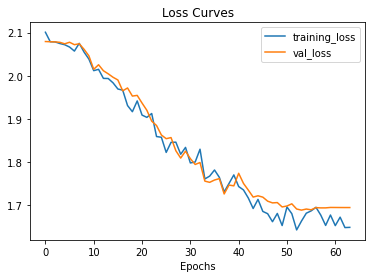

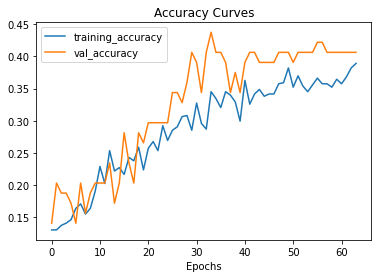

In [18]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) 

model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
erl_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)
mod_chk = ModelCheckpoint(filepath = 'content/drive/My Drive/modelCNNrugaya/hacktiv8_project/cnn.h5', monitor = 'val_loss', save_best_only=True)
lr_rate = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor=0.1)

history = model.fit(train_data, 
                    epochs=epochs, 
                    validation_data=val_data,
                    callbacks=[erl_stop, mod_chk, lr_rate], verbose=2)

plot_loss_curves(history)

Train modelnya berhenti di epoch 63 dikarenakan pada epoch 53 val_loss-nya sebesar 1.6906 karena 10 epoch selanjutnya tidak menghasilkan val_loss yang lebih kecil sehingga train modelnya berhenti pada epoch 63 sebagai best_model.

In [22]:
loss, acc = model.evaluate(test_data, verbose=1)
print(" The Model, Loss:{:5.2f} and Accuracy: {:5.2f}% ".format(loss, 100*acc))

10/10 [==============================] - 5s 503ms/step - loss: 1.8080 - accuracy: 0.3291
 The Model, Loss: 1.81 and Accuracy: 32.91% 


Dilakukan evaluasi pada model terbaik transfer learning dengan epoch 63 dan didapatkan akurasi sebesar 32.91% dan loss 1.81

In [19]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

In [20]:
# =============TESTING=============
print("==============TEST RESULTS============")                                                                
predictions = model.predict(test_data, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_data.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

==============TEST RESULTS============
10/10 [==============================] - 4s 357ms/step
Accuracy  : 0.10759493670886076
Precision : 0.08850560168700226
f1Score : 0.09526912030635039
[[5 2 2 2 4 5 0 2]
 [3 0 1 2 5 3 0 3]
 [2 3 1 2 4 3 0 2]
 [6 1 3 3 3 4 0 4]
 [3 4 1 3 1 5 0 3]
 [1 2 0 6 3 6 1 0]
 [3 2 1 4 5 5 0 2]
 [3 1 2 2 6 1 1 1]]


Classification Report
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.19      0.23      0.21        22
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.00      0.00      0.00        17
                                          Atopic Dermatitis Photos       0.09      0.06      0.07        17
                      Light Diseases and Disorders of Pigmentation       0.12      0.12      0.12        24
                        Lupus and other Connective Tissue diseases       0.03      0.05      0.04        20
            Tinea Ringworm Candidiasis and other Fungal Infections       0.19      0.32      0.24        19
                                                   Vascular Tumors       0.00      0.00      0.00        22
                        Warts Molluscum and other Viral Infections       0.06      0.06      0.06        17

    

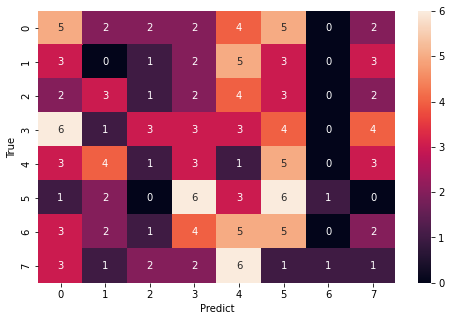

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

target_names = ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Vascular Tumors', 'Warts Molluscum and other Viral Infections']
print('Classification Report')
print(classification_report(true_classes, yPredictions, target_names=target_names))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(true_classes, yPredictions), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("True")
plt.show()

Dari hasil classification report diatas, terlihat bahwa:
1. Nilai akurasi sebesar 10%, precission sebesar 9% dan f1score sebesar 8% yang menunjukkan model belum cukup baik karena dari 100% data yang ada, model hanya mampu memprediksi benar sebesar 10%
2. Pada confussion matrix yang merupakan hasil predict model terhadap data test, terlihat bahwa: 


    *   Pada kelas 0 dari total 22 gambar model hanya mampu memprediksi benar 5 gambar
    *   Pada kelas 1 dari total 17 gambar model tidak mampu memprediksi benar semua data yang ada
    *   Pada kelas 2 dari total 17 gambar model hanya mampu memprediksi benar 1 gambar
    *   Pada kelas 3 dari total 24 gambar model hanya mampu memprediksi benar 3 gambar
    *   Pada kelas 4 dari total 20 gambar model hanya mampu memprediksi benar 5 gambar
    *   Pada kelas 5 dari total 18 gambar model hanya mampu memprediksi benar 6 gambar
    *   Pada kelas 6 dari total 22 gambar model tidak mampu memprediksi benar semua data yang ada
    *   Pada kelas 7 dari total 17 gambar model hanya mampu memprediksi benar 1 gambar

Dengan mempertimbangkan hasil pada classification report yang belum cukup baik dengan model terbaik yang saya dapatkan, saya memutuskan untuk menggunakan transfer learning untuk membangun model klasifikasi pada kasus skin disease.

#8. TRAIN DAN EVALUASI TRANSFER LEARNING

Training model dengan arsitektur best model yang saya dapatkan diatas, belum cukup menghasilkan hasil yang cukup baik. Sehingga saya memutuskan untuk menggunakan transfer learning dengan arsitektur model MobileNetV2.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNet,MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
mobnetV2_conv = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
for layer in (mobnetV2_conv.layers):
    layer.trainable = False

Pada bagian multi layer perceptron saya memutuskan menggunakan 2 hidden layer dengan dropout sebesar 0.2, sebesar 512 pada hidden layer pertama dan 128 neuron pada hidden layer kedua.

Saya menggunakan Callback EarlyStopping dengan patience = 10 untuk train model transfer learning yang saya gunakan dengan epoch sebesar 100 epoch.

In [ ]:
model = Sequential()

# Add the MobilNetV2 convolutional base model
model.add(mobnetV2_conv)
model.add(AveragePooling2D(pool_size=(7, 7)))# average pooling gives the average of features present in a patch. 
# Add new layers
model.add(Flatten(name="flatten")) #converting the data into a 1-dimensional array for inputting it to the next layer
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2)) #a technique used to prevent a model from overfitting.
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation="softmax"))

model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

epochs = 100
erl_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)
mod_chk = ModelCheckpoint(filepath = 'content/drive/My Drive/modelCNNrugaya/hacktiv8_project/cnn.h5', monitor = 'val_loss', save_best_only=True)
lr_rate = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor=0.1)

history = model.fit(train_data, 
                    epochs=epochs, 
                    validation_data=val_data,
                    callbacks=[erl_stop, mod_chk, lr_rate], verbose=2)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


46/46 - 45s - loss: 1.9895 - accuracy: 0.2431 - val_loss: 1.6491 - val_accuracy: 0.3667 - lr: 0.0010 - 45s/epoch - 970ms/step
Epoch 2/100
46/46 - 13s - loss: 1.6522 - accuracy: 0.3887 - val_loss: 1.3715 - val_accuracy: 0.5111 - lr: 0.0010 - 13s/epoch - 272ms/step
Epoch 3/100
46/46 - 12s - loss: 1.4882 - accuracy: 0.4560 - val_loss: 1.4022 - val_accuracy: 0.4556 - lr: 0.0010 - 12s/epoch - 265ms/step
Epoch 4/100
46/46 - 13s - loss: 1.3343 - accuracy: 0.5014 - val_loss: 1.1665 - val_accuracy: 0.6222 - lr: 0.0010 - 13s/epoch - 277ms/step
Epoch 5/100
46/46 - 12s - loss: 1.2676 - accuracy: 0.5371 - val_loss: 1.4580 - val_accuracy: 0.4833 - lr: 0.0010 - 12s/epoch - 266ms/step
Epoch 6/100
46/46 - 12s - loss: 1.2752 - accuracy: 0.5357 - val_loss: 1.3487 - val_accuracy: 0.5167 - lr: 0.0010 - 12s/epoch - 266ms/step
Epoch 7/100
46/46 - 12s - loss: 1.1505 - accuracy: 0.5948 - val_loss: 1.1408 - val_accuracy: 0.6111 - lr: 0.0010 - 12s/epoch - 271ms/step
Epoch 8/100
46/46 - 12s - loss: 1.1549 - accur

Train modelnya berhenti di epoch 48 dikarenakan pada epoch 38 val_loss-nya sebesar 0.7092 karena 10 epoch selanjutnya tidak menghasilkan val_loss yang lebih kecil sehingga train modelnya berhenti pada epoch 48 sebagai best_model.

In [ ]:
loss, acc = model.evaluate(test_data, verbose=1)
print(" The Model, Loss:{:5.2f} and Accuracy: {:5.2f}% ".format(loss, 100*acc))

17/17 [==============================] - 2s 103ms/step - loss: 0.6634 - accuracy: 0.7917
 The Model, Loss: 0.66 and Accuracy: 79.17% 


Dilakukan evaluasi pada model terbaik transfer learning dengan epoch 48 dan didapatkan akurasi sebesar 79.17% dan loss 0.66

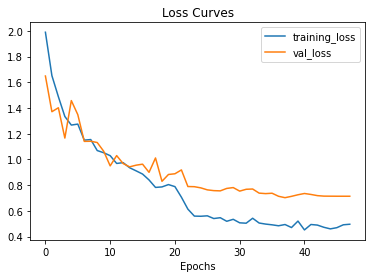

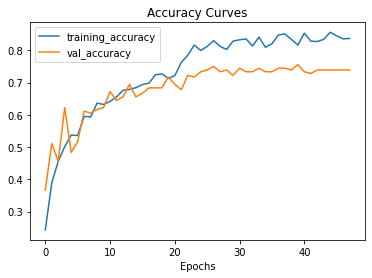

In [ ]:
plot_loss_curves(history)

Hasil visualisasi menunjukkan performa model yang cukup baik karena dengan semakin bertambahnya epoch terjadi improve pada nilai akurasi dan loss, nilai akurasi semakin mendekati 1 (meningkat) dan nilai loss semakin mendekati 0 (menurun) walaupun agak overfit.

In [ ]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

In [ ]:
# =============TESTING=============
print("==============TEST RESULTS============")                                                                
predictions = model.predict(test_data, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_data.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

==============TEST RESULTS============
17/17 [==============================] - 3s 156ms/step
Accuracy  : 0.14015151515151514
Precision : 0.14287937882859938
f1Score : 0.14098130521055421
[[3 4 4 8 4 5 3 3]
 [4 4 4 4 3 7 3 3]
 [7 3 6 2 4 4 5 0]
 [5 3 6 4 6 7 3 5]
 [6 4 6 3 3 3 2 3]
 [2 4 6 6 4 4 4 4]
 [7 6 4 4 3 3 7 1]
 [0 4 2 4 6 3 4 6]]


Classification Report
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.09      0.09      0.09        34
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.12      0.12      0.12        32
                                          Atopic Dermatitis Photos       0.16      0.19      0.17        31
                      Light Diseases and Disorders of Pigmentation       0.11      0.10      0.11        39
                        Lupus and other Connective Tissue diseases       0.09      0.10      0.10        30
            Tinea Ringworm Candidiasis and other Fungal Infections       0.11      0.12      0.11        34
                                                   Vascular Tumors       0.23      0.20      0.21        35
                        Warts Molluscum and other Viral Infections       0.24      0.21      0.22        29

    

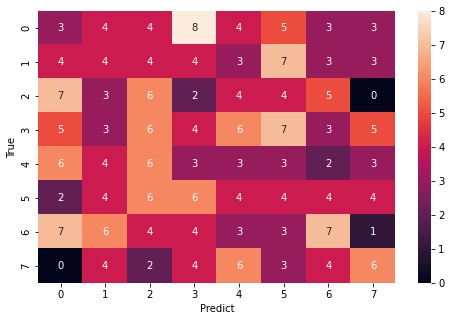

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

target_names = ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Vascular Tumors', 'Warts Molluscum and other Viral Infections']
print('Classification Report')
print(classification_report(true_classes, yPredictions, target_names=target_names))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(true_classes, yPredictions), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("True")
plt.show()

Dari hasil classification report diatas, terlihat bahwa:
1. Nilai akurasi, precission dan f1score masing-masing sekitar 14% yang menunjukkan model belum cukup baik karena dari 100% data yang ada, model hanya mampu memprediksi benar sebesar 14%
2. Pada confussion matrix yang merupakan hasil predict model terhadap data test, terlihat bahwa: 


    *   Pada kelas 0 dari total 34 gambar model hanya mampu memprediksi benar 3 gambar
    *   pada kelas 1 dari total 32 gambar model hanya mampu memprediksi benar 4 gambar
    *   Pada kelas 2 dari total 31 gambar model hanya mampu memprediksi benar 6 gambar
    *   Pada kelas 3 dari total 39 gambar model hanya mampu memprediksi benar 4 gambar
    *   Pada kelas 4 dari total 30 gambar model hanya mampu memprediksi benar 3 gambar
    *   Pada kelas 5 dari total 34 gambar model hanya mampu memprediksi benar 4 gambar
    *   Pada kelas 6 dari total 35 gambar model hanya mampu memprediksi benar 7 gambar
    *   Pada kelas 7 dari total 29 gambar model hanya mampu memprediksi benar 6 gambar

Dengan mempertimbangkan hasil pada classification report yang belum cukup baik dengan model transfer learning, saya memutuskan untuk train model transfer learning menggunakan Cross validation.

Karena ada salah satu kelas yang memiliki jumlah data yang berbeda, sehingga saya memutuskan untuk menggunakan Stratified Cross Validation agar dapat menjaga proporsi data tiap kelas untuk selalu ada di setiap fold. Saya menggunakan 5-fold dengan mempertimbangkan jumlah data yang saya punya (790 data gambar)

#9. TRAINING DAN EVALUASI TRANSFER LEARNING WITH 5-FOLD STRATIFIED CROSS VALIDATION

In [ ]:
datasetFolderName='dataset/'
MODEL_FILENAME="/content/drive/My Drive/modelCNNrugaya/hacktiv8_project/cnn_model.h5"
sourceFiles=[]
classLabels=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Vascular Tumors', 'Warts Molluscum and other Viral Infections']
def transferBetweenFolders(source, dest, splitRate):   
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/', 
                               datasetFolderName+'/'+dest+'/'+label+'/', 
                               splitRate)


# First, check if test folder is empty or not, if not transfer all existing files to train
transferAllClassBetweenFolders('test', 'train', 1.0)
# Now, split some part of train data into the test folders.
transferAllClassBetweenFolders('train', 'test', 0.20)


X=[]
Y=[]

def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        if(folderName==classLabels[0]):
            Y.append(0)
        elif(folderName==classLabels[1]):
            Y.append(1)
        elif(folderName==classLabels[2]):
            Y.append(2)
        elif(folderName==classLabels[3]):
            Y.append(3)
        elif(folderName==classLabels[4]):
            Y.append(4)
        elif(folderName==classLabels[5]):
            Y.append(5)
        elif(folderName==classLabels[6]):
            Y.append(6)
        elif(folderName==classLabels[7]):
            Y.append(7)
        else:
            Y.append(8)

# Organize file names and class labels in X and Y variables
prepareNameWithLabels(classLabels[0])
prepareNameWithLabels(classLabels[1])
prepareNameWithLabels(classLabels[2])
prepareNameWithLabels(classLabels[3])
prepareNameWithLabels(classLabels[4])
prepareNameWithLabels(classLabels[5])  
prepareNameWithLabels(classLabels[6])
prepareNameWithLabels(classLabels[7])

X=np.asarray(X)
Y=np.asarray(Y)

In [ ]:
model = Sequential()

# Add the MobilNetV2 convolutional base model
model.add(mobnetV2_conv)
model.add(AveragePooling2D(pool_size=(7, 7)))# average pooling gives the average of features present in a patch. 
# Add new layers
model.add(Flatten(name="flatten")) #converting the data into a 1-dimensional array for inputting it to the next layer
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2)) #a technique used to prevent a model from overfitting.
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation="softmax"))

model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
train_path=datasetFolderName+'/train/'
validation_path=datasetFolderName+'/validation/'
test_path=datasetFolderName+'/test/'

In [ ]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

In [ ]:
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import random

# ===============Stratified 5-Fold======================
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('validation', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        if(Y_val[eachIndex]==0):
            classLabel=classLabels[0]
        elif(Y_val[eachIndex]==1):
            classLabel=classLabels[1]
        elif(Y_val[eachIndex]==2):
            classLabel=classLabels[2]
        elif(Y_val[eachIndex]==3):
            classLabel=classLabels[3]
        elif(Y_val[eachIndex]==4):
            classLabel=classLabels[4]
        elif(Y_val[eachIndex]==5):
            classLabel=classLabels[5]
        elif(Y_val[eachIndex]==6):
            classLabel=classLabels[6]
        else:
            classLabel=classLabels[7]   
        #Then, copy the validation images to the validation folder
        shutil.move(datasetFolderName+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    datasetFolderName+'/validation/'+classLabel+'/'+X_val[eachIndex])

    #Augmentasi Citra    
    train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.25,
                height_shift_range=0.25,
                shear_range=0.20,
        		    zoom_range=0.20,
                horizontal_flip=True,
               	fill_mode="nearest"
                )
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
        
    #Start ImageClassification Model
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=16,
        class_mode='categorical',
        subset='training')

    validation_generator = validation_datagen.flow_from_directory(
            validation_path,
            target_size=(224,224),
            batch_size=16,
            class_mode=None,  # only data, no labels
            shuffle=False)   
   
    # fit model
    history=model.fit_generator(train_generator, 
                        epochs=50)
    
    predictions = model.predict_generator(validation_generator, verbose=1)
    yPredictions = np.argmax(predictions, axis=1)
    true_classes = validation_generator.classes
    # evaluate validation performance
    print("***Performance on Validation data***")    
    valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)

Results for fold 1
Found 530 images belonging to 8 classes.
Found 117 images belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
34/34 [==============================] - 13s 378ms/step - loss: 1.2406 - accuracy: 0.5774
Epoch 2/50
34/34 [==============================] - 8s 248ms/step - loss: 1.1968 - accuracy: 0.5849
Epoch 3/50
34/34 [==============================] - 8s 241ms/step - loss: 1.0773 - accuracy: 0.6113
Epoch 4/50
34/34 [==============================] - 8s 239ms/step - loss: 1.0739 - accuracy: 0.6226
Epoch 5/50
34/34 [==============================] - 8s 239ms/step - loss: 1.0324 - accuracy: 0.6509
Epoch 6/50
34/34 [==============================] - 8s 239ms/step - loss: 1.0437 - accuracy: 0.6585
Epoch 7/50
34/34 [==============================] - 8s 241ms/step - loss: 0.9678 - accuracy: 0.6755
Epoch 8/50
34/34 [==============================] - 8s 240ms/step - loss: 1.0191 - accuracy: 0.6358
Epoch 9/50
34/34 [==============================] - 8s 240ms/step - loss: 0.8856 - accuracy: 0.7019
Epoch 10/50
34/34 [==============================] - 8s 240ms/step - loss: 0.8666 - accuracy: 0.715

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


8/8 [==============================] - 1s 97ms/step
***Performance on Validation data***
Accuracy  : 0.5128205128205128
Precision : 0.5357671466570411
f1Score : 0.5083526557552663
[[13  0  0  1  0  1  1  0]
 [ 1  9  1  1  0  0  1  1]
 [ 0  0  7  0  1  0  5  2]
 [ 5  2  0  7  0  0  1  0]
 [ 2  1  1  0  5  2  2  0]
 [ 2  3  0  1  0  4  3  2]
 [ 1  0  1  1  2  2  7  0]
 [ 1  2  0  0  1  1  2  8]]
Results for fold 2
Found 530 images belonging to 8 classes.
Found 117 images belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
34/34 [==============================] - 8s 242ms/step - loss: 0.6839 - accuracy: 0.7792
Epoch 2/50
34/34 [==============================] - 8s 240ms/step - loss: 0.6218 - accuracy: 0.8038
Epoch 3/50
34/34 [==============================] - 8s 243ms/step - loss: 0.5914 - accuracy: 0.8170
Epoch 4/50
34/34 [==============================] - 8s 241ms/step - loss: 0.6792 - accuracy: 0.7868
Epoch 5/50
34/34 [==============================] - 8s 240ms/step - loss: 0.5111 - accuracy: 0.8377
Epoch 6/50
34/34 [==============================] - 8s 242ms/step - loss: 0.4593 - accuracy: 0.8396
Epoch 7/50
34/34 [==============================] - 8s 244ms/step - loss: 0.5762 - accuracy: 0.8208
Epoch 8/50
34/34 [==============================] - 8s 240ms/step - loss: 0.4559 - accuracy: 0.8453
Epoch 9/50
34/34 [==============================] - 8s 239ms/step - loss: 0.4833 - accuracy: 0.8283
Epoch 10/50
34/34 [==============================] - 8s 239ms/step - loss: 0.4774 - accuracy: 0.8509

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


8/8 [==============================] - 1s 97ms/step
***Performance on Validation data***
Accuracy  : 0.7863247863247863
Precision : 0.7983155733155732
f1Score : 0.7854187292452031
[[11  0  0  2  0  0  1  1]
 [ 1 12  0  0  0  1  0  1]
 [ 1  0 12  0  0  0  1  1]
 [ 0  0  0 14  0  1  0  0]
 [ 0  1  0  0 10  2  0  0]
 [ 0  0  0  0  0 14  0  1]
 [ 0  1  2  0  1  2  8  0]
 [ 2  0  0  0  0  2  0 11]]
Results for fold 3
Found 530 images belonging to 8 classes.
Found 117 images belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
34/34 [==============================] - 8s 240ms/step - loss: 0.4935 - accuracy: 0.8491
Epoch 2/50
34/34 [==============================] - 8s 240ms/step - loss: 0.4620 - accuracy: 0.8245
Epoch 3/50
34/34 [==============================] - 8s 240ms/step - loss: 0.3831 - accuracy: 0.8623
Epoch 4/50
34/34 [==============================] - 8s 240ms/step - loss: 0.4430 - accuracy: 0.8472
Epoch 5/50
34/34 [==============================] - 8s 241ms/step - loss: 0.4670 - accuracy: 0.8472
Epoch 6/50
34/34 [==============================] - 8s 241ms/step - loss: 0.4376 - accuracy: 0.8623
Epoch 7/50
34/34 [==============================] - 8s 242ms/step - loss: 0.3439 - accuracy: 0.8887
Epoch 8/50
34/34 [==============================] - 8s 242ms/step - loss: 0.2813 - accuracy: 0.9038
Epoch 9/50
34/34 [==============================] - 8s 238ms/step - loss: 0.2751 - accuracy: 0.9019
Epoch 10/50
34/34 [==============================] - 8s 240ms/step - loss: 0.3312 - accuracy: 0.8906

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


8/8 [==============================] - 1s 96ms/step
***Performance on Validation data***
Accuracy  : 0.8461538461538461
Precision : 0.8725036684484844
f1Score : 0.8427468813798003
[[15  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0]
 [ 0  0 14  0  0  1  0  0]
 [ 5  1  0  7  1  0  0  0]
 [ 0  0  0  0 11  3  0  0]
 [ 2  0  0  0  0 11  1  0]
 [ 0  0  1  0  0  0 14  0]
 [ 1  0  0  0  1  0  1 12]]
Results for fold 4
Found 531 images belonging to 8 classes.
Found 116 images belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
34/34 [==============================] - 8s 243ms/step - loss: 0.3812 - accuracy: 0.8795
Epoch 2/50
34/34 [==============================] - 8s 241ms/step - loss: 0.3160 - accuracy: 0.8964
Epoch 3/50
34/34 [==============================] - 8s 241ms/step - loss: 0.4148 - accuracy: 0.8757
Epoch 4/50
34/34 [==============================] - 9s 250ms/step - loss: 0.2935 - accuracy: 0.9058
Epoch 5/50
34/34 [==============================] - 8s 243ms/step - loss: 0.2778 - accuracy: 0.9171
Epoch 6/50
34/34 [==============================] - 8s 244ms/step - loss: 0.2782 - accuracy: 0.9002
Epoch 7/50
34/34 [==============================] - 8s 243ms/step - loss: 0.2421 - accuracy: 0.9153
Epoch 8/50
34/34 [==============================] - 8s 248ms/step - loss: 0.2232 - accuracy: 0.9247
Epoch 9/50
34/34 [==============================] - 8s 242ms/step - loss: 0.2624 - accuracy: 0.9171
Epoch 10/50
34/34 [==============================] - 8s 243ms/step - loss: 0.2651 - accuracy: 0.9190

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


8/8 [==============================] - 1s 136ms/step
***Performance on Validation data***
Accuracy  : 0.896551724137931
Precision : 0.8998873210967532
f1Score : 0.8941755480131452
[[14  0  0  0  0  0  0  1]
 [ 0 15  0  0  0  0  0  0]
 [ 0  0 13  0  0  1  0  0]
 [ 0  0  0 15  0  0  0  0]
 [ 0  0  0  0 14  0  0  0]
 [ 0  0  1  0  1 11  1  0]
 [ 1  0  0  0  2  1 10  1]
 [ 0  0  2  0  0  0  0 12]]
Results for fold 5
Found 531 images belonging to 8 classes.
Found 116 images belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
34/34 [==============================] - 8s 241ms/step - loss: 0.2490 - accuracy: 0.9190
Epoch 2/50
34/34 [==============================] - 8s 242ms/step - loss: 0.2392 - accuracy: 0.9077
Epoch 3/50
34/34 [==============================] - 8s 241ms/step - loss: 0.2915 - accuracy: 0.9002
Epoch 4/50
34/34 [==============================] - 8s 240ms/step - loss: 0.2672 - accuracy: 0.9096
Epoch 5/50
34/34 [==============================] - 8s 242ms/step - loss: 0.2012 - accuracy: 0.9341
Epoch 6/50
34/34 [==============================] - 8s 241ms/step - loss: 0.1743 - accuracy: 0.9360
Epoch 7/50
34/34 [==============================] - 8s 242ms/step - loss: 0.2508 - accuracy: 0.9077
Epoch 8/50
34/34 [==============================] - 8s 243ms/step - loss: 0.1615 - accuracy: 0.9473
Epoch 9/50
34/34 [==============================] - 8s 244ms/step - loss: 0.1838 - accuracy: 0.9397
Epoch 10/50
34/34 [==============================] - 8s 241ms/step - loss: 0.1841 - accuracy: 0.9435

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


8/8 [==============================] - 1s 94ms/step
***Performance on Validation data***
Accuracy  : 0.853448275862069
Precision : 0.8838464696223317
f1Score : 0.8533306081977978
[[15  0  0  0  0  0  0  0]
 [ 2 11  0  0  0  0  1  0]
 [ 4  0  9  0  1  0  0  1]
 [ 0  0  0 14  0  0  0  1]
 [ 0  0  0  0 12  1  0  0]
 [ 1  0  0  0  0 14  0  0]
 [ 1  0  0  1  1  1 11  0]
 [ 1  0  0  0  0  0  0 13]]


    Akurasi per-fold:
    *   Fold 1: 0.5128205128205128
    *   Fold 2: 0.7863247863247863
    *   Fold 3: 0.8461538461538461
    *   Fold 4: 0.896551724137931
    *   Fold 5: 0.853448275862069

Mean Akurasi: 77.902%


In [ ]:
loss, acc = model.evaluate(test_data, verbose=1)
print(" The Model, Loss:{:5.2f} and Accuracy: {:5.2f}% ".format(loss, 100*acc))

17/17 [==============================] - 4s 157ms/step - loss: 0.9278 - accuracy: 0.7727
 The Model, Loss: 0.93 and Accuracy: 77.27% 


Dilakukan evaluasi pada model terbaik transfer learning dengan epoch 48 dan didapatkan akurasi sebesar 77.27% dan loss 0.93

In [ ]:
# =============TESTING=============
print("==============TEST RESULTS============")                                                                
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode=None,
        shuffle=False) 
predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

==============TEST RESULTS============
Found 143 images belonging to 8 classes.
9/9 [==============================] - 1s 146ms/step
Accuracy  : 0.6433566433566433
Precision : 0.6365188428233742
f1Score : 0.6371663069599279
[[14  1  0  3  0  0  0  1]
 [ 1 16  0  0  0  1  0  0]
 [ 2  0 13  0  1  0  1  1]
 [ 2  2  1 12  0  0  1  0]
 [ 0  2  2  0  5  1  4  2]
 [ 2  0  0  0  1 11  1  3]
 [ 1  0  1  1  2  3 10  0]
 [ 0  0  0  1  2  2  2 11]]


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Classification Report
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.64      0.74      0.68        19
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.76      0.89      0.82        18
                                          Atopic Dermatitis Photos       0.76      0.72      0.74        18
                      Light Diseases and Disorders of Pigmentation       0.71      0.67      0.69        18
                        Lupus and other Connective Tissue diseases       0.45      0.31      0.37        16
            Tinea Ringworm Candidiasis and other Fungal Infections       0.61      0.61      0.61        18
                                                   Vascular Tumors       0.53      0.56      0.54        18
                        Warts Molluscum and other Viral Infections       0.61      0.61      0.61        18

    

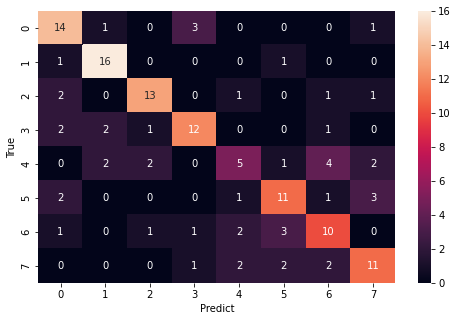

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

target_names = ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Vascular Tumors', 'Warts Molluscum and other Viral Infections']
print('Classification Report')
print(classification_report(true_classes, yPredictions, target_names=target_names))
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(true_classes, yPredictions), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("True")
plt.show()

Dari hasil classification report diatas, terlihat bahwa:
1. Nilai akurasi sebesar 64%, precission sebesar 63% dan f1score sebesar 63% yang menunjukkan model sudah cukup baik karena dari 100% data yang ada, model mampu memprediksi benar sebesar 64% artinya model bisa memprediksi benar lebih banyak dibandingkan dengan yang salah prediksi (sebesar 36%)
2. Pada confussion matrix yang merupakan hasil predict model terhadap data test, terlihat bahwa: 


    *   Pada kelas 0 dari total 19 gambar model mampu memprediksi benar 14 gambar
    *   pada kelas 1 dari total 19 gambar model mampu memprediksi benar 16 gambar
    *   Pada kelas 2 dari total 18 gambar model mampu memprediksi benar 13 gambar
    *   Pada kelas 3 dari total 17 gambar model hanya mampu memprediksi benar 12 gambar
    *   Pada kelas 4 dari total 16 gambar model hanya mampu memprediksi benar 5 gambar
    *   Pada kelas 5 dari total 18 gambar model hanya mampu memprediksi benar 11 gambar
    *   Pada kelas 6 dari total 18 gambar model hanya mampu memprediksi benar 10 gambar
    *   Pada kelas 7 dari total 18 gambar model hanya mampu memprediksi benar 11 gambar

Dibandingkan dengan hasil 2 classification report sebelumnya, Model transfer learning di train dengan Stratified 5-fold Cross Validation menghasilkan performa model yang sudah cukup baik karena mampu memprediksi benar lebih banyak dibandingkan dengan salah prediksi. Sehingga saya memutuskan menggunakan model ini untuk digunakan pada tahapan model inference hingga deployment di streamlit.

In [ ]:
model.save(MODEL_FILENAME)

#10. MODEL INFERENCE

Pada tahapan model inference sebelum dilakukan predict ada beberapa tahapan preprocessing yang dilakukan:
1. Set input_size sesuai input_size pada train model
2. Mendefinisikan labels sesuai dengan labels pada train model
3. Rescake new image data

In [ ]:
# Parameters
input_size = (224, 224)

#define labels
labels = ['Acne and Rosacea Photos', 
          'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 
          'Atopic Dermatitis Photos', 'Light Diseases and Disorders of Pigmentation', 
          'Lupus and other Connective Tissue diseases', 
          'Tinea Ringworm Candidiasis and other Fungal Infections', 
          'Vascular Tumors', 
          'Warts Molluscum and other Viral Infections']

In [ ]:
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

In [ ]:
from tensorflow.keras.models import load_model
from PIL import Image

In [ ]:
MODEL_PATH = '/content/drive/My Drive/modelCNNrugaya/hacktiv8_project/cnn_model.h5'
model = load_model(MODEL_PATH,compile=False)

In [ ]:
# read image
im = Image.open('07AcnePittedScars1.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )

Acne and Rosacea Photos 1.0


#11. KESIMPULAN

Saya melakukan 3 experiment untuk mendapatkan model terbaik:
1. Mendefinisikan jaringan arsitektur dan mencari model terbaik kemudian di train dengan 100 epoch dengan jumlah drop out sebesar 0.2 dan menggunakan callback EarlyStopping
2. Mengadopsi jaringan konvolusi pada MobileNetV2 dengan metode transfer learning, kemudian di train dengan 100 epoch dan menggunakan callback EarlyStopping
3. Train model transfer learning dengan Stratified 5-fold Cross Validation

Dari ketiga percobaan diatas, model yang menghasilkan performa terbaik adalah Model transfer learning dengan train model menggunakan Stratified 5-fold Cross Validation

Dari percobaan yang saya lakukan juga, terlihat pada kasus saya imbalanced data memiliki pengaruh yang cukup besar dengan performa model yang dihasilkan. Terbukti setelah dilakukan training dengan Stratified CV, performa model yang dihasilkan cukup baik.